# Plots to import into TikZ



In [1]:
from pathlib import Path
import re
import matplotlib.pyplot as plt
import tikzplotlib
from plots_utils import plot_averaged_training_charts, plot_comparison, show_timestamp_info

import plots_utils
plots_utils.abbreviations['noise'] = r'NOISE'

figures_dir = Path("figures")
figures_dir.mkdir(exist_ok=True)

In [2]:
number_formats = {1e6: '10^6', 1e3: '10^3', 1.0: '1', 0.1: '0.1', 1e-2: '0.01'}

def modify_for_tikz(ax=None):
    """Hacks to make it more suitable for TikZ.
     - remove the title
     - remove sample sizes from legends
     - for legend labels, put the whole equation in LaTeX
    """
    if ax is None:
        ax = plt.gca()
    
    ax.set_title('')
    
    for child in ax.get_children():
        label = child.get_label()
        if not isinstance(label, str):
            continue
        if label in ["analog", "digital"]:
            child.set_label(r"\tiny " + label)
        match = re.match(r"NOISE=([\de\.-]+) \((\d+) / (\d+)\)", label)
        if not match:
            continue
        noise = float(match.group(1))
        power = 1.0
        snr = power / noise
        new_label = r"\tiny $P / \sigma_\mathrm{n}^2 = " + number_formats[snr] + "$"
        child.set_label(new_label)
        
        analog_samples, digital_samples = match.group(2), match.group(3)
        print(f"noise = {noise}: {analog_samples} analog samples, {digital_samples} digital_samples")
    
    ax.legend()

# Logistic regression

In [3]:
analog_path = [Path("../results-downloaded/20210722-dynpower-2/"), Path("../results-downloaded/20210723-lownoise-dynpower"), Path("../results-downloaded/20210724-epsilon-dynpower")]
digital_path = [Path("../results-downloaded/20210722-dynquant/"), Path("../results-downloaded/20210723-lownoise-dynquant"), Path("../results-downloaded/20210724-epsilon-dynquant")]

def get_comparison_specs(clients, send, zero_bits_strategy, noise):

    common_fixed_specs = {
        'rounds': 150,
        'batch_size': 64,
        'lr_client': 0.01,
        'momentum_client': 0.0,
        'epochs': 1,
        'dataset': 'epsilon',
        'ema_coefficient': 1 / 3,
        'data_per_client': 20000,
    }

    fixed_specs = common_fixed_specs.copy()
    fixed_specs.update({
        'power_update_period': 1,
        'power_quantile': 0.9,
        'power_factor': 0.9,
    })
    title_specs = {
        'power': 1.0,
        'clients': clients,
        'send': send,
    }
    series_specs = {
        'noise': noise,
    }

    all_analog_specs = title_specs, fixed_specs, series_specs

    fixed_specs = common_fixed_specs.copy()
    fixed_specs.update({
        'qrange_update_period': 1,
        'qrange_param_quantile': 0.9,
        'qrange_client_quantile': 0.9,
        'channel_uses': None,
        'rounding_method': ['stochastic', '__missing__'],
    })
    title_specs = title_specs.copy()
    title_specs.update({
        'zero_bits_strategy': zero_bits_strategy,
    })

    all_digital_specs = title_specs, fixed_specs, series_specs
    
    return all_analog_specs, all_digital_specs

noise = 1e-06: 10 analog samples, 10 digital_samples
noise = 0.001: 9 analog samples, 9 digital_samples
noise = 1.0: 11 analog samples, 11 digital_samples
noise = 10.0: 11 analog samples, 11 digital_samples


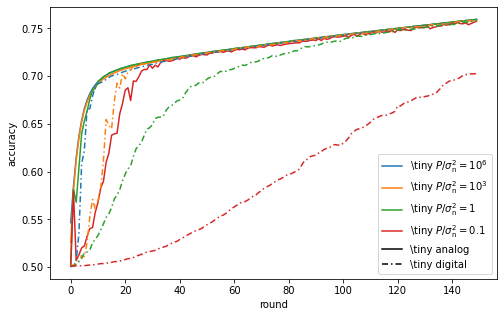

In [4]:
all_specs = get_comparison_specs(5, 'deltas', 'read-zero', [1e-6, 1e-3, 1, 10])
plot_comparison('accuracy', analog_path, digital_path, *all_specs)
modify_for_tikz()
tikzplotlib.save(figures_dir / "epsilon-n5.tikz")

noise = 1e-06: 10 analog samples, 10 digital_samples
noise = 0.001: 9 analog samples, 8 digital_samples
noise = 1.0: 10 analog samples, 10 digital_samples
noise = 100.0: 10 analog samples, 10 digital_samples


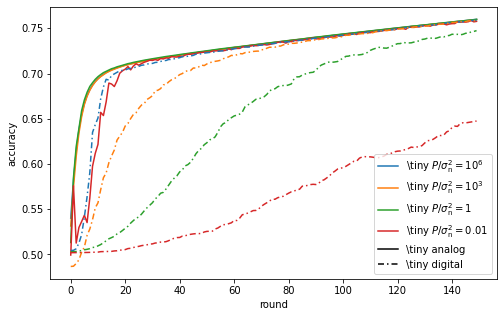

In [5]:
all_specs = get_comparison_specs(20, 'deltas', 'read-zero', [1e-6, 1e-3, 1, 100])
plot_comparison('accuracy', analog_path, digital_path, *all_specs)
modify_for_tikz()
tikzplotlib.save(figures_dir / "epsilon-n20.tikz")

# CIFAR-10 and Fashion-MNIST

In [6]:
analog_path = Path("../results-downloaded/20210724-other-datasets-dynpower/")
digital_path = Path("../results-downloaded/20210724-other-datasets-dynquant/")

def get_comparison_args(dataset, clients, lr_client=0.01, momentum_client=0.0):
    common_fixed_specs = {
        'rounds': 150,
        'batch_size': 64,
        'epochs': 1,
        'ema_coefficient': 1 / 3,
        'data_per_client': None,
    }

    fixed_specs = common_fixed_specs.copy()
    fixed_specs.update({
        'power_update_period': 1,
        'power_quantile': 0.9,
        'power_factor': 0.9,
    })
    title_specs = {
        'power': 1.0,
        'dataset': dataset,
        'clients': clients,
        'send': 'deltas',
        'momentum_client': momentum_client,
        'lr_client': lr_client,
    }
    series_specs = {
        'noise': '__all__',
    }
    all_analog_specs = title_specs, fixed_specs, series_specs

    fixed_specs = common_fixed_specs.copy()
    fixed_specs.update({
        'qrange_update_period': 1,
        'qrange_param_quantile': 0.9,
        'qrange_client_quantile': 0.9,
        'channel_uses': None,
        'rounding_method': 'stochastic',
        'zero_bits_strategy': 'read-zero',
    })

    all_digital_specs = title_specs, fixed_specs, series_specs
    
    return all_analog_specs, all_digital_specs

noise = 1e-06: 9 analog samples, 9 digital_samples
noise = 0.001: 8 analog samples, 8 digital_samples
noise = 1.0: 8 analog samples, 8 digital_samples


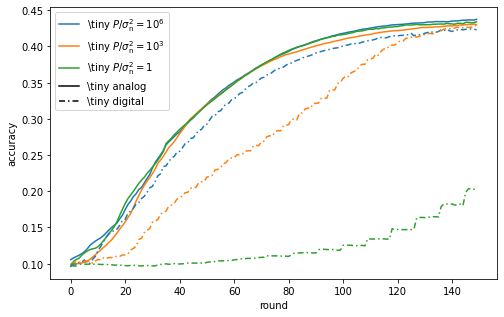

In [7]:
all_specs = get_comparison_args('cifar10', 20, lr_client=1e-3, momentum_client=0.9)
plot_comparison('accuracy', analog_path, digital_path, *all_specs)
modify_for_tikz()
tikzplotlib.save(figures_dir / "cifar10.tikz")

noise = 1e-06: 12 analog samples, 12 digital_samples
noise = 0.001: 12 analog samples, 12 digital_samples
noise = 1.0: 4 analog samples, 12 digital_samples


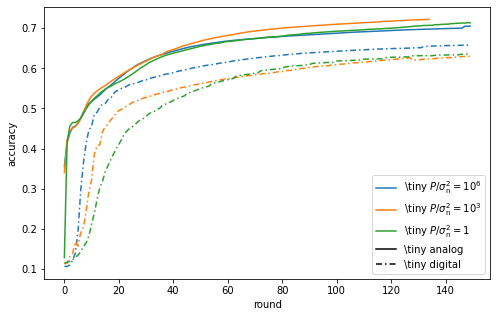

In [8]:
all_specs = get_comparison_args('fashion-mnist', 20)
plot_comparison('accuracy', analog_path, digital_path, *all_specs)
modify_for_tikz()
tikzplotlib.save(figures_dir / "fashion-mnist.tikz")